In [1]:
# Install catboost
!pip install catboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder,RobustScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
!ls -l /content/sample_data

total 55504
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Jun 17 13:37 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Jun 17 13:37 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Jun 17 13:37 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Jun 17 13:37 mnist_train_small.csv
-rwxr-xr-x 1 root root      962 Jan  1  2000 README.md


In [4]:
data = pd.read_csv('/content/customer_support_tickets.csv')

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

In [6]:
print(data.describe())

         Ticket ID  Customer Age  Customer Satisfaction Rating
count  8469.000000   8469.000000                   2769.000000
mean   4235.000000     44.026804                      2.991333
std    2444.934048     15.296112                      1.407016
min       1.000000     18.000000                      1.000000
25%    2118.000000     31.000000                      2.000000
50%    4235.000000     44.000000                      3.000000
75%    6352.000000     57.000000                      4.000000
max    8469.000000     70.000000                      5.000000


In [7]:
print(data.head())

   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   

  Customer Gender Product Purchased Date of Purchase      Ticket Type  \
0           Other        GoPro Hero       2021-03-22  Technical issue   
1          Female       LG Smart TV       2021-05-22  Technical issue   
2           Other          Dell XPS       2020-07-14  Technical issue   
3          Female  Microsoft Office       2020-11-13  Billing inquiry   
4          Female  Autodesk AutoCAD       2020-02-04  Billing inquiry   

             Ticket Subject  \
0             Product setup   
1  Peripheral compatibil

In [8]:
common_issues = data['Ticket Subject'].value_counts().head(10)
print("Top 10 Common Issues:")
print(common_issues)

Top 10 Common Issues:
Ticket Subject
Refund request           576
Software bug             574
Product compatibility    567
Delivery problem         561
Hardware issue           547
Battery life             542
Network problem          539
Installation support     530
Product setup            529
Payment issue            526
Name: count, dtype: int64


In [9]:
print(data.columns)

Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating'],
      dtype='object')


In [10]:
print(data.dtypes)

Ticket ID                         int64
Customer Name                    object
Customer Email                   object
Customer Age                      int64
Customer Gender                  object
Product Purchased                object
Date of Purchase                 object
Ticket Type                      object
Ticket Subject                   object
Ticket Description               object
Ticket Status                    object
Resolution                       object
Ticket Priority                  object
Ticket Channel                   object
First Response Time              object
Time to Resolution               object
Customer Satisfaction Rating    float64
dtype: object


In [11]:
data['Customer Satisfaction Rating'].fillna(0, inplace=True)
data['Customer Satisfaction Rating'] = data['Customer Satisfaction Rating'].astype(int)

/tmp/ipython-input-11-3449719356.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Customer Satisfaction Rating'].fillna(0, inplace=True)


In [12]:
print(data['Customer Satisfaction Rating'].describe())
print(data['Customer Satisfaction Rating'].unique())


count    8469.000000
mean        0.978038
std         1.617538
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         5.000000
Name: Customer Satisfaction Rating, dtype: float64
[0 3 1 4 5 2]


In [13]:
print(data[['Ticket Priority', 'Customer Satisfaction Rating']].dropna().head())

  Ticket Priority  Customer Satisfaction Rating
0        Critical                             0
1        Critical                             0
2             Low                             3
3             Low                             3
4             Low                             1


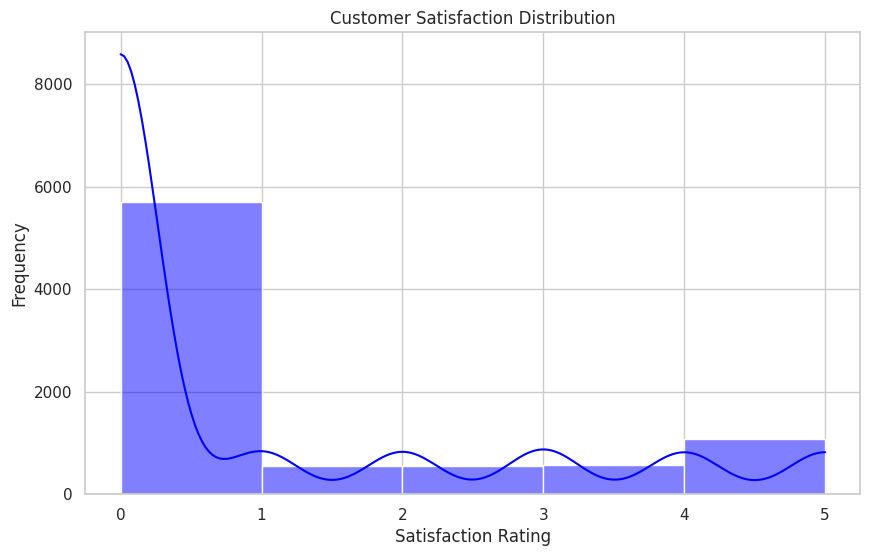

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['Customer Satisfaction Rating'], bins=5,
kde=True, color='blue')
plt.title('Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Frequency')
plt.show()

In [15]:
data['Resolution'].fillna('No Resolution', inplace=True)

/tmp/ipython-input-15-1781044822.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Resolution'].fillna('No Resolution', inplace=True)


In [16]:
data['Time to Resolution'] = data['Time to Resolution'].fillna(pd.Timedelta(0))
data['Time to Resolution'].fillna(pd.Timedelta(0), inplace=True)


/tmp/ipython-input-16-2548475754.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Time to Resolution'].fillna(pd.Timedelta(0), inplace=True)


In [17]:
data['First Response Time'] = data['First Response Time'].fillna(data['First Response Time'].mode()[0])
data['First Response Time'].fillna(data['First Response Time'].mode()[0], inplace=True)


/tmp/ipython-input-17-1230687644.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['First Response Time'].fillna(data['First Response Time'].mode()[0], inplace=True)


In [18]:
data['Time to Resolution'].fillna(pd.Timedelta(0), inplace=True)
data['First Response Time'].fillna(data['First Response Time'].mode()[0], inplace=True)
data['First Response Time'] = pd.to_datetime(data['First Response Time'])

/tmp/ipython-input-18-1495873040.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Time to Resolution'].fillna(pd.Timedelta(0), inplace=True)
/tmp/ipython-input-18-1495873040.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [19]:
data['First Response Time'] = pd.to_datetime(data['First Response Time'], errors='coerce')
data['Date of Purchase'] = pd.to_datetime(data['Date of Purchase'], errors='coerce')

In [20]:
data['Ticket Age'] = (data['First Response Time'] - data['Date of Purchase'])


In [21]:
median_ticket_age = data['Ticket Age'].median()

In [22]:
data['Ticket Age'].fillna(median_ticket_age, inplace=True)


/tmp/ipython-input-22-860130016.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Ticket Age'].fillna(median_ticket_age, inplace=True)


In [23]:
data['Ticket Age'] = data['Ticket Age'].dt.days

In [24]:
data['Ticket Age'].fillna(data['Ticket Age'].median(), inplace=True)

/tmp/ipython-input-24-2481765773.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Ticket Age'].fillna(data['Ticket Age'].median(), inplace=True)


In [25]:
print(data['Time to Resolution'].head())

0        0 days 00:00:00
1        0 days 00:00:00
2    2023-06-01 18:05:38
3    2023-06-01 01:57:40
4    2023-06-01 19:53:42
Name: Time to Resolution, dtype: object


In [26]:
print(data['Time to Resolution'].unique())

[Timedelta('0 days 00:00:00') '2023-06-01 18:05:38' '2023-06-01 01:57:40'
 ... '2023-06-01 06:58:07' '2023-06-01 04:31:22' '2023-06-01 05:32:24']


In [27]:
print(data.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age',
       'Customer Gender', 'Product Purchased', 'Date of Purchase',
       'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status',
       'Resolution', 'Ticket Priority', 'Ticket Channel',
       'First Response Time', 'Time to Resolution',
       'Customer Satisfaction Rating', 'Ticket Age'],
      dtype='object')>


In [28]:
data.columns=data.columns.str.strip()

In [29]:
data['Time to Resolution']

0           0 days 00:00:00
1           0 days 00:00:00
2       2023-06-01 18:05:38
3       2023-06-01 01:57:40
4       2023-06-01 19:53:42
               ...         
8464        0 days 00:00:00
8465        0 days 00:00:00
8466    2023-06-01 04:31:22
8467    2023-06-01 05:32:24
8468        0 days 00:00:00
Name: Time to Resolution, Length: 8469, dtype: object

In [30]:
data['Time to Resolution'] = pd.to_timedelta(data['Time to Resolution'], errors='coerce')

In [31]:
data['Time to Resolution'] = data['Time to Resolution'].dt.total_seconds()
data['Time to Resolution'] = data['Time to Resolution'].astype(float)

In [32]:
data['Time to Resolution (in hours)'] = data['Time to Resolution']/ 3600


In [33]:
print(data['Time to Resolution'].head())
print(data['Time to Resolution'].dtype)

0    0.0
1    0.0
2    NaN
3    NaN
4    NaN
Name: Time to Resolution, dtype: float64
float64


In [34]:
data['Days Since Purchase'] = (data['First Response Time'] - data['Date of Purchase']).dt.days
data['Days Since Purchase'].fillna(data['Days Since Purchase'].median(), inplace=True)

/tmp/ipython-input-34-439456831.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Days Since Purchase'].fillna(data['Days Since Purchase'].median(), inplace=True)


In [35]:
data['Response Delay Hours'] = (data['First Response Time'] - data['Date of Purchase']).dt.total_seconds() / 3600
data['Response Delay Hours'].fillna(data['Response Delay Hours'].median(), inplace=True)

/tmp/ipython-input-35-1450436204.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Response Delay Hours'].fillna(data['Response Delay Hours'].median(), inplace=True)


In [36]:
# Ensure 'Resolution Duration Hours' is numeric, coercing errors to NaN
data['Resolution Duration Hours'] = pd.to_numeric(data['Time to Resolution']/ 3600, errors='coerce')

# Calculate the median on the now purely numeric column
median_resolution_duration = data['Resolution Duration Hours'].median()

# Fill missing values with the calculated median
data['Resolution Duration Hours'].fillna(median_resolution_duration, inplace=True)

/tmp/ipython-input-36-3206867892.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Resolution Duration Hours'].fillna(median_resolution_duration, inplace=True)


In [37]:
data['Priority_Channel'] = data['Ticket Priority'] + '_' + data['Ticket Channel']
data['Age Group'] = pd.cut(data['Customer Age'], bins=[0, 30, 45, 60, 100], labels=['Young', 'Adult', 'Middle-Aged', 'Senior'])
data['Age_TicketType'] = data['Age Group'].astype(str) + '_' + data['Ticket Type']


In [38]:
data['Ticket Description'] = data['Ticket Description'].str.replace('product_purchase', '')

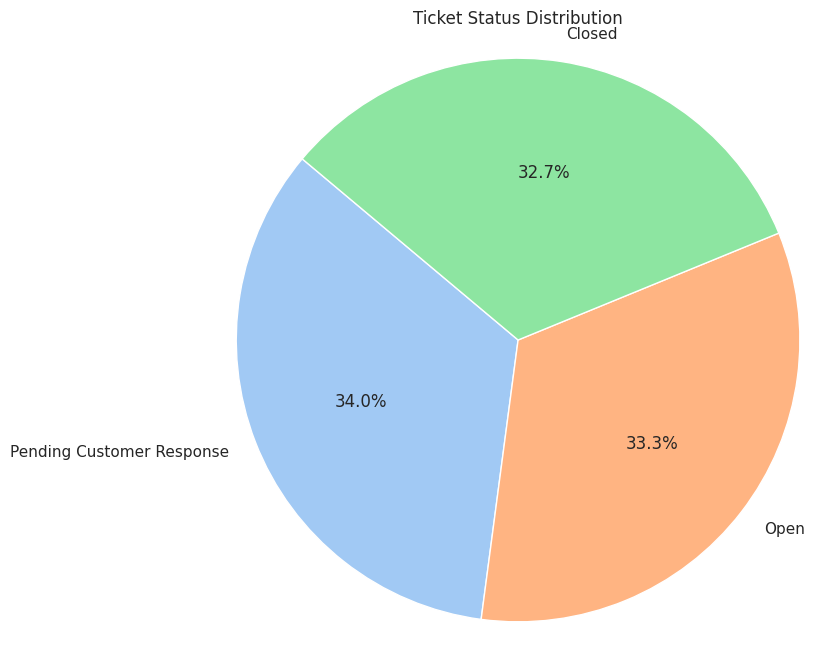

In [39]:
#Ticket Status Distribution
ticket_status_distribution = data['Ticket Status'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(ticket_status_distribution, labels=ticket_status_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
plt.title('Ticket Status Distribution')
plt.axis('equal')
plt.show()

In [40]:
sid = SentimentIntensityAnalyzer()
data['Sentiment Score'] = data['Ticket Description'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

In [41]:
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['Ticket Description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
data = pd.concat([data, tfidf_df], axis=1)

In [42]:
data['Word Count'] = data['Ticket Description'].apply(lambda x: len(str(x).split()))

In [43]:
data['Customer Age'] = pd.to_numeric(data['Customer Age'], errors='coerce')

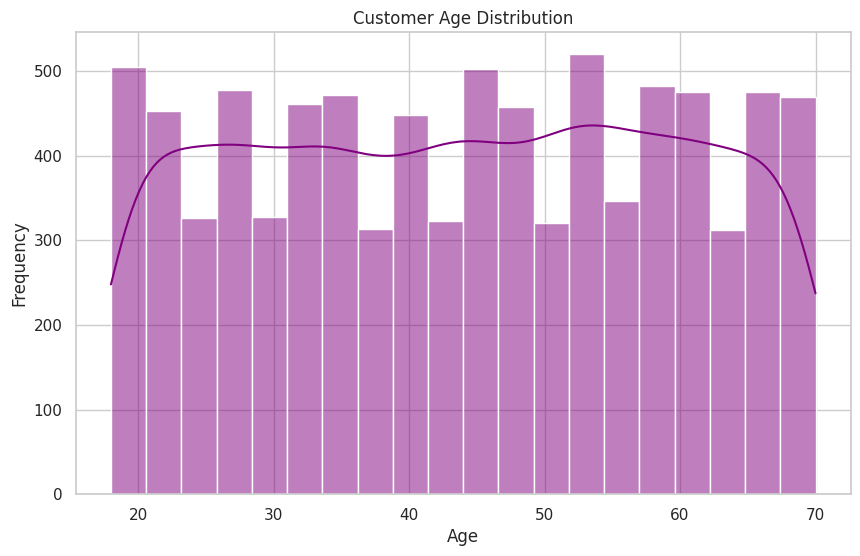

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Customer Age'], bins=20, kde=True,
color='purple')
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

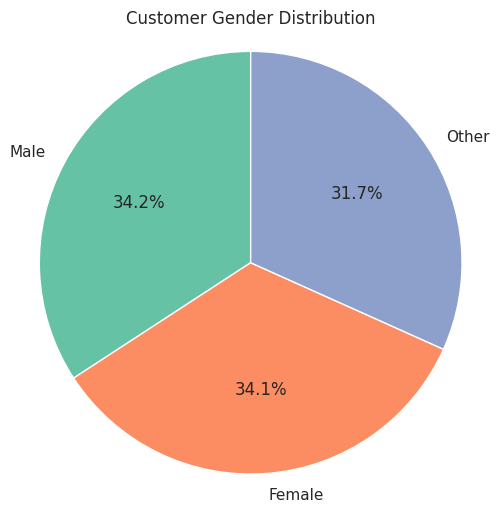

In [45]:
customer_gender_distribution = data['Customer Gender'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(customer_gender_distribution, labels=customer_gender_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('Set2'), startangle=90)
plt.title('Customer Gender Distribution')
plt.axis('equal')
plt.show()

In [46]:
data['Customer Satisfaction Rating'] = data['Customer Satisfaction Rating'].astype(int)

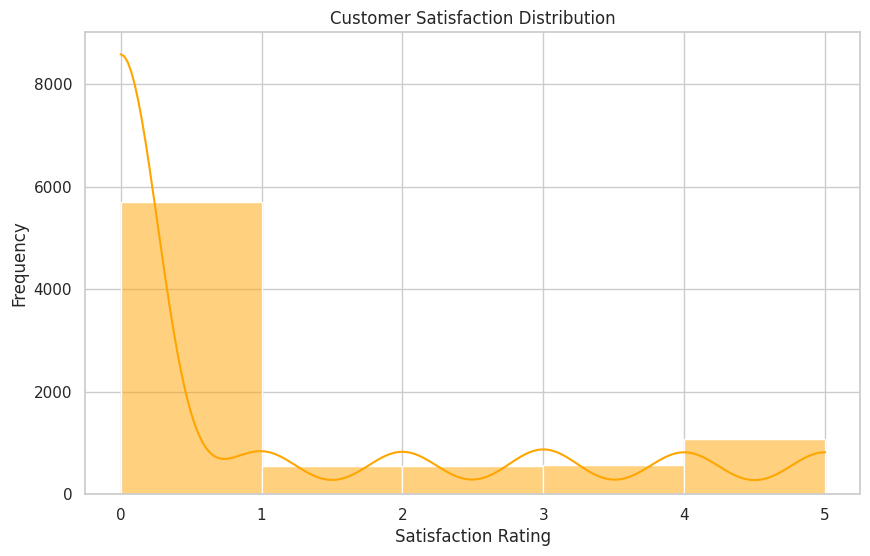

In [47]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data['Customer Satisfaction Rating'], bins=5,
kde=True, color='orange')
plt.title('Customer Satisfaction Distribution')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Frequency')
plt.show()

In [48]:
ticket_type_segmentation = data.groupby('Ticket Type').size()
print("\nSegmentation based on Ticket Types:")
print(ticket_type_segmentation)


Segmentation based on Ticket Types:
Ticket Type
Billing inquiry         1634
Cancellation request    1695
Product inquiry         1641
Refund request          1752
Technical issue         1747
dtype: int64


In [49]:
satisfaction_segmentation = data.groupby('Customer Satisfaction Rating').size()
ticket_type_segmentation = data.groupby('Ticket Type').size()
print("\nSegmentation based on Ticket Types:")


Segmentation based on Ticket Types:


In [50]:
satisfaction_segmentation = data.groupby('Customer Satisfaction Rating').size()
print("\nSegmentation based on Customer Satisfaction Levels:")
print(satisfaction_segmentation)
print("\nSegmentation based on Customer Satisfaction Levels:")
print(satisfaction_segmentation)


Segmentation based on Customer Satisfaction Levels:
Customer Satisfaction Rating
0    5700
1     553
2     549
3     580
4     543
5     544
dtype: int64

Segmentation based on Customer Satisfaction Levels:
Customer Satisfaction Rating
0    5700
1     553
2     549
3     580
4     543
5     544
dtype: int64


In [51]:
sid = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Ticket Description'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [52]:
tfidf = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['Ticket Description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{i}' for i in range(50)])
data = pd.concat([data, tfidf_df], axis=1)

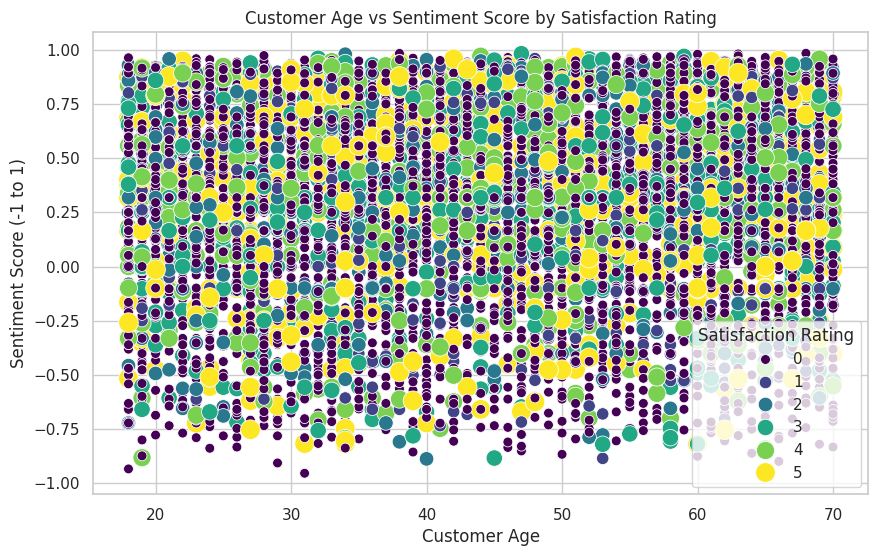

In [53]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Customer Age',y='Sentiment Score',hue='Customer Satisfaction Rating',palette='viridis',size='Customer Satisfaction Rating',sizes=(50, 200),data=data)
plt.title('Customer Age vs Sentiment Score by Satisfaction Rating')
plt.xlabel('Customer Age')
plt.ylabel('Sentiment Score (-1 to 1)')
plt.legend(title='Satisfaction Rating', loc='best')
plt.grid(True)
plt.show()

In [54]:
data['Channel Interaction Score'] = data.groupby(['Customer Email', 'Ticket Channel'])['Ticket ID'].transform('count')

/tmp/ipython-input-55-3037534369.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Customer Satisfaction Rating', y='Sentiment Score', data=data, palette='pastel')


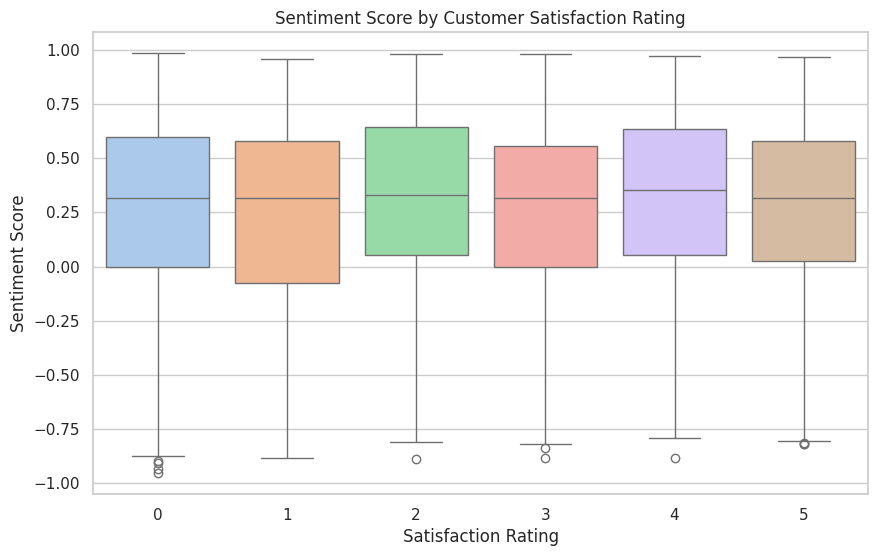

In [55]:
#Sentiment vs Satisfaction
plt.figure(figsize=(10, 6))
sns.boxplot(x='Customer Satisfaction Rating', y='Sentiment Score', data=data, palette='pastel')
plt.title('Sentiment Score by Customer Satisfaction Rating')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Sentiment Score')
plt.show()

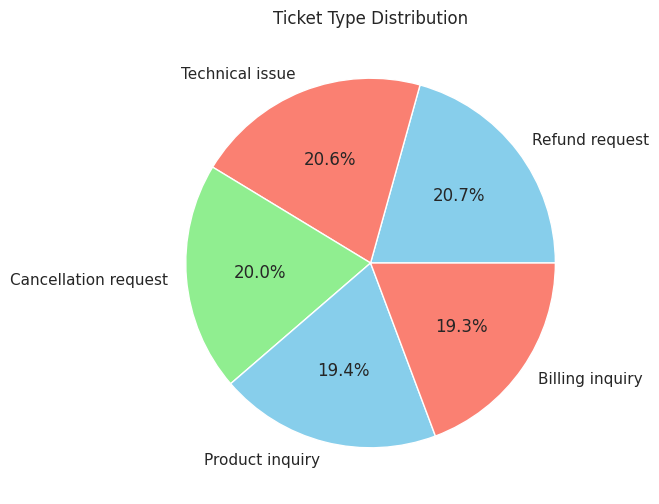

In [56]:
# Count ticket types
ticket_type_distribution = data['Ticket Type'].value_counts()
# Plot
plt.figure(figsize=(8, 6))
ticket_type_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon', 'lightgreen'])
plt.title('Ticket Type Distribution')
plt.ylabel('')
plt.show()

In [57]:
def target_encode(column, target, data):
    means = data.groupby(column)[target].mean()
    return data[column].map(means)

for col in ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject', 'Ticket Priority', 'Ticket Channel']:
    data[f'{col}_encoded'] = target_encode(col, 'Customer Satisfaction Rating', data)

In [58]:
numerical_cols = ['Customer Age', 'Ticket Age', 'Response Delay Hours', 'Resolution Duration Hours', 'Sentiment Score', 'Word Count', 'Channel Interaction Score']
encoded_cols = [f'{col}_encoded' for col in ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject', 'Ticket Priority', 'Ticket Channel']]
X = data[numerical_cols + encoded_cols]
y = data['Customer Satisfaction Rating'].astype(int) # No subtraction needed, XGBoost handles multi-class from 0

In [59]:
# Ticket Complexity (unique words in description)
data['Ticket Complexity'] = data['Ticket Description'].apply(lambda x: len(set(str(x).split())))

# Customer Loyalty Score (tickets per customer)
data['Customer Loyalty Score'] = data.groupby('Customer Email')['Ticket ID'].transform('count')

# Day of Week
data['Day of Week'] = data['First Response Time'].dt.day_name()

In [60]:
categorical_cols = ['Customer Gender', 'Product Purchased', 'Ticket Type', 'Ticket Subject', 'Ticket Priority', 'Ticket Channel']

In [61]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[categorical_cols] = encoder.fit_transform(data[categorical_cols])

In [62]:
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

/tmp/ipython-input-62-3373751560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [63]:
all_numerical_features = numerical_cols + encoded_cols

In [64]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool # Keep existing imports if not already present

# Rest of your code for defining base_estimators and stacking_model
base_estimators = [
    ('catboost', CatBoostClassifier(random_state=42, verbose=0, iterations=100, learning_rate=0.1)),
    ('logreg', LogisticRegression(random_state=42, multi_class='multinomial', max_iter=1000))]
stacking_model = StackingClassifier(estimators=base_estimators,final_estimator=RandomForestClassifier(random_state=42, n_estimators=50),cv=5)

In [65]:
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), all_numerical_features)],remainder='passthrough') # Keep other columns (like tfidf features))

In [66]:
pipeline = Pipeline([('preprocessor', preprocessor),('classifier', XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1))])


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


In [68]:
stacking_model.fit(X_train, y_train)

# Predictions
y_pred = stacking_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [69]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Customer Age', 'Ticket Age',
                                                   'Response Delay Hours',
                                                   'Resolution Duration Hours',
                                                   'Sentiment Score',
                                                   'Word Count',
                                                   'Channel Interaction Score',
                                                   'Customer Gender_encoded',
                                                   'Product Purchased_encoded',
                                                   'Ticket Type_encoded',
                                                   'Ticket Subject_encoded',
                                                   'Ticket Prior...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [70]:
y_pred = pipeline.predict(X_test)

In [71]:
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [72]:
# Initialize and train the CatBoost model
model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, random_seed=42, verbose=0, auto_class_weights='Balanced')
model.fit(train_pool)

In [73]:
y_pred = model.predict(test_pool)


In [77]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42, n_estimators=100, learning_rate=0.05, num_leaves=31, class_weight='balanced')
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 6351, number of used features: 12
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


LGBMClassifier(class_weight='balanced', learning_rate=0.05, random_state=42)

In [74]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.254957507082153
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.32      0.43      1426
           1       0.08      0.19      0.11       138
           2       0.05      0.11      0.07       137
           3       0.06      0.12      0.08       145
           4       0.06      0.14      0.09       136
           5       0.05      0.09      0.06       136

    accuracy                           0.25      2118
   macro avg       0.17      0.16      0.14      2118
weighted avg       0.49      0.25      0.32      2118

Confusion Matrix:
 [[450 212 202 197 188 177]
 [ 34  26  20  24  22  12]
 [ 35  20  15  20  24  23]
 [ 52  24  18  18  21  12]
 [ 37  20  19  24  19  17]
 [ 41  16  15  18  34  12]]


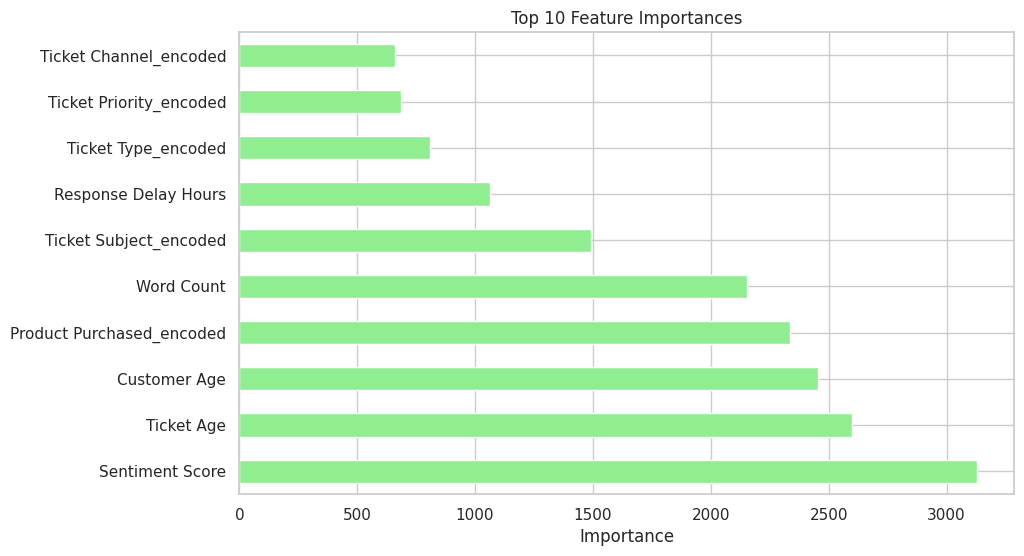

In [78]:
feature_importance = pd.Series(lgbm.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importance.nlargest(10).plot(kind='barh', color='lightgreen')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.show()

/tmp/ipython-input-79-3829561331.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticket_channel_distribution.index,


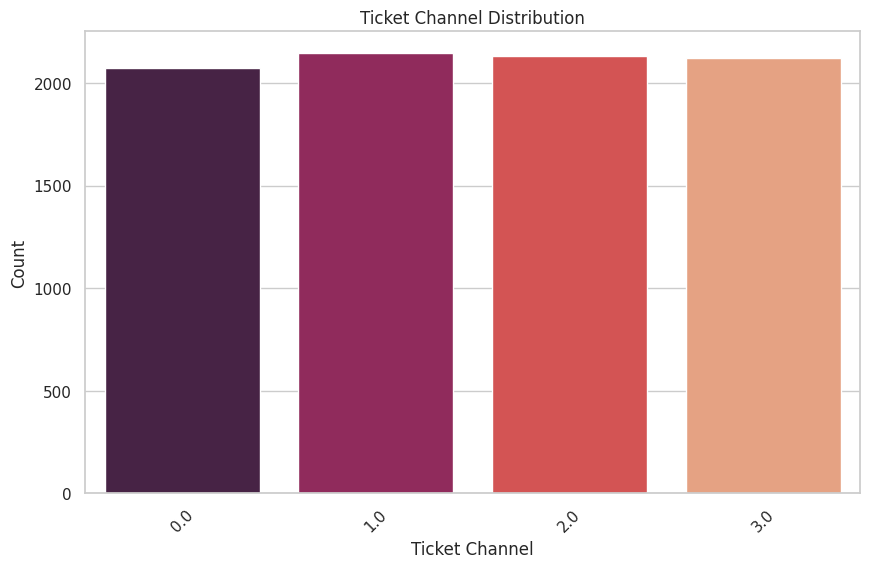

In [79]:
#Ticket Channel Distribution
plt.figure(figsize=(10, 6))
ticket_channel_distribution = data['Ticket Channel'].value_counts()
sns.barplot(x=ticket_channel_distribution.index,
y=ticket_channel_distribution, palette='rocket')
plt.title('Ticket Channel Distribution')
plt.xlabel('Ticket Channel')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


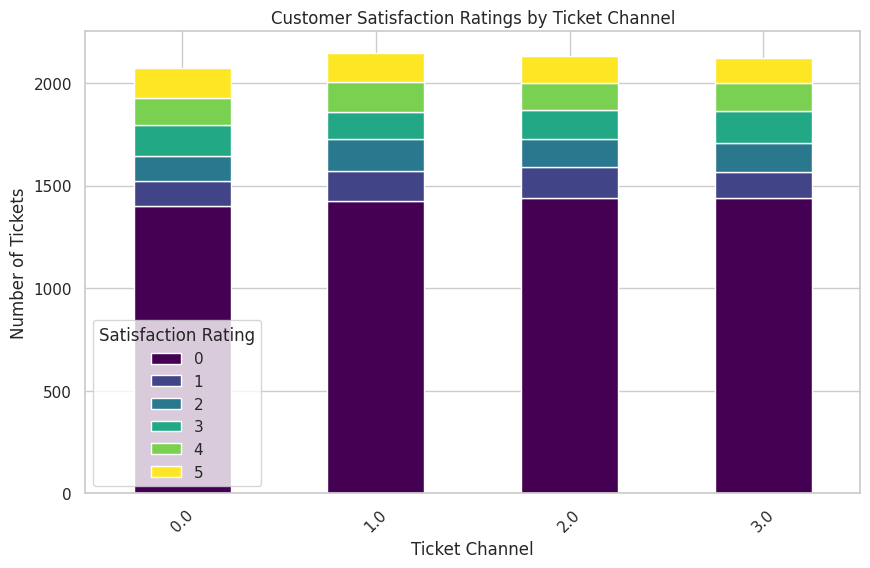

In [80]:
# Stacked Bar Chart: Satisfaction by Ticket Channel
pivot_table = data.pivot_table(index='Ticket Channel', columns='Customer Satisfaction Rating', values='Ticket ID', aggfunc='count', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title('Customer Satisfaction Ratings by Ticket Channel')
plt.xlabel('Ticket Channel')
plt.ylabel('Number of Tickets')
plt.legend(title='Satisfaction Rating')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-81-2031535398.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Customer Satisfaction Rating', y='Sentiment Score', data=data, palette='coolwarm')


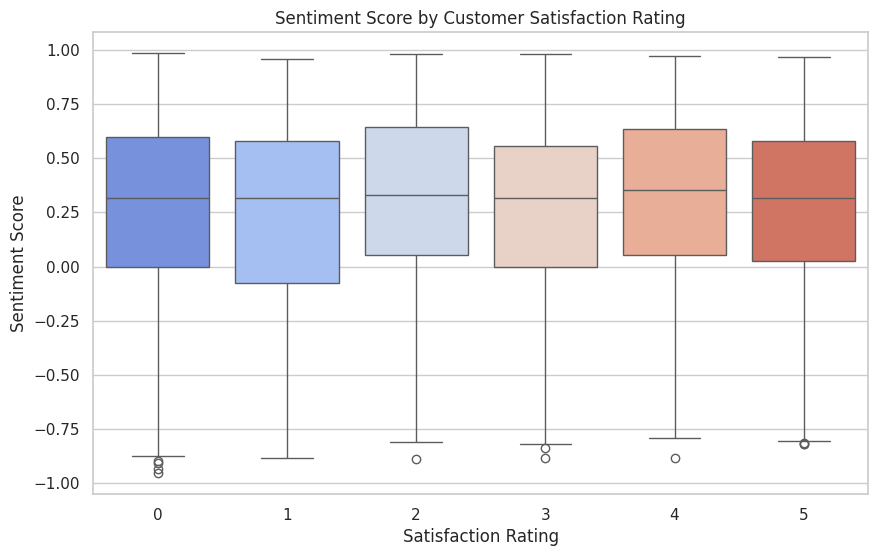

In [81]:
# Sentiment vs Satisfaction Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Customer Satisfaction Rating', y='Sentiment Score', data=data, palette='coolwarm')
plt.title('Sentiment Score by Customer Satisfaction Rating')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Sentiment Score')
plt.show()

/tmp/ipython-input-82-3109580700.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Ticket Priority', y='Customer Age', data=data, palette='Set2')


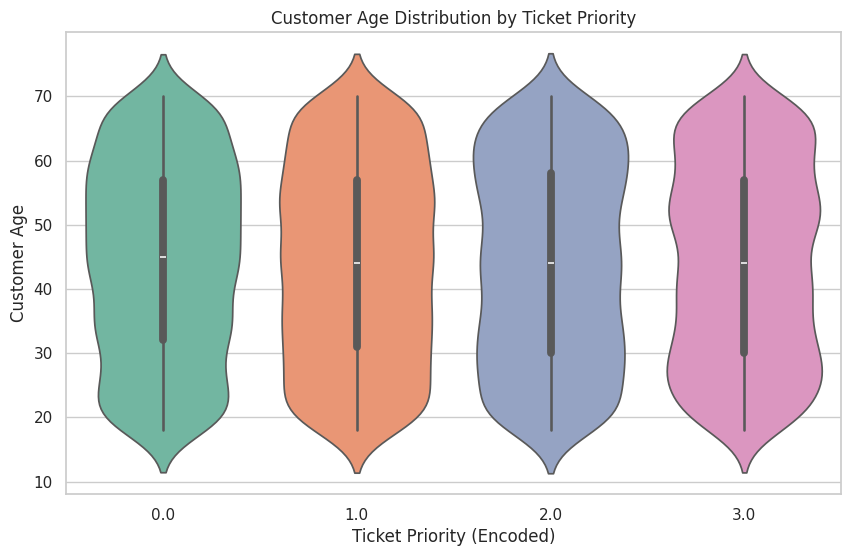

In [82]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='Ticket Priority', y='Customer Age', data=data, palette='Set2')
plt.title('Customer Age Distribution by Ticket Priority')
plt.xlabel('Ticket Priority (Encoded)')
plt.ylabel('Customer Age')
plt.show()

/tmp/ipython-input-83-3263338432.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=product_purchased_distribution.index,


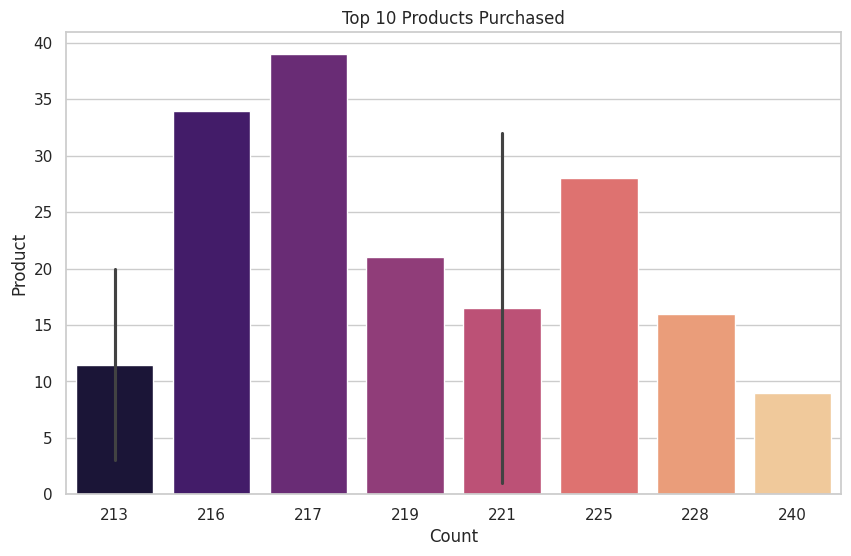

In [83]:
plt.figure(figsize=(10, 6))
product_purchased_distribution = data['Product Purchased'].value_counts().head(10)
sns.barplot(y=product_purchased_distribution.index,
x=product_purchased_distribution, palette='magma')
plt.title('Top 10 Products Purchased')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show()

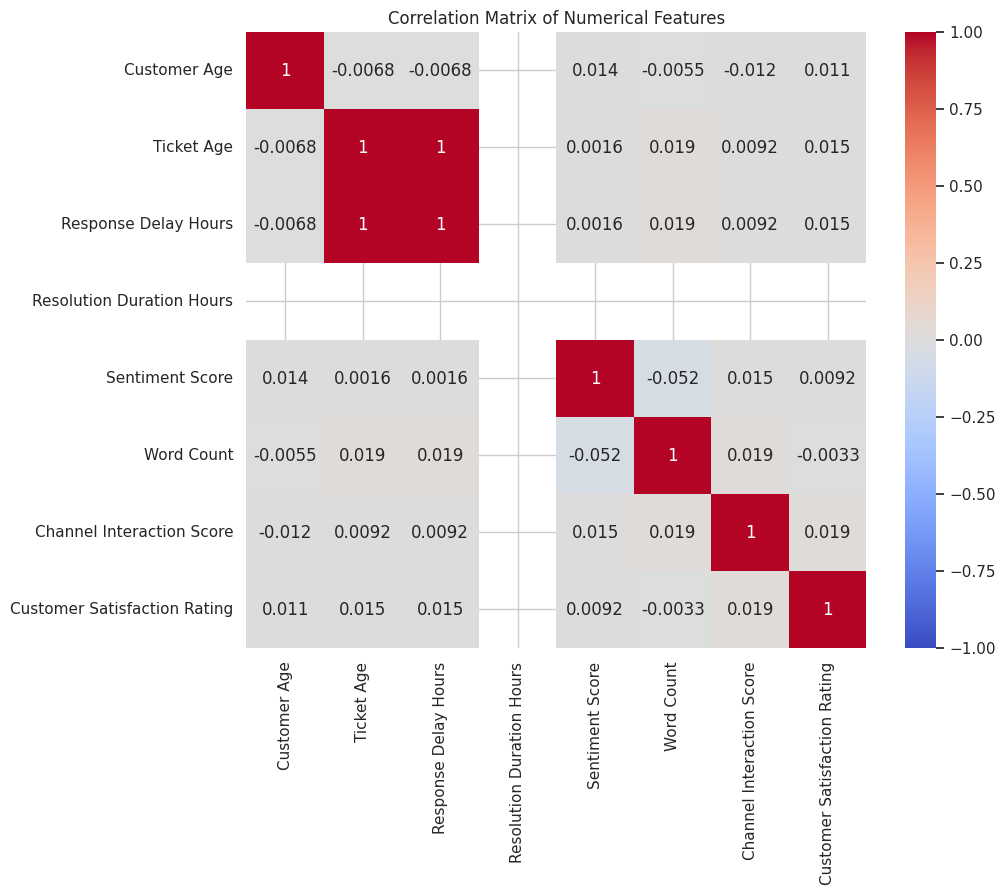

In [84]:
#Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data[numerical_cols + ['Customer Satisfaction Rating']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

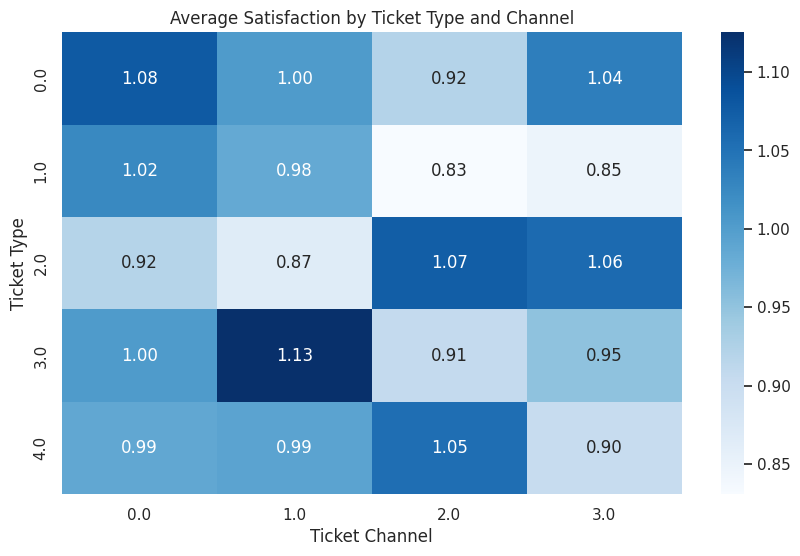

In [85]:
#Heatmap: Ticket Type vs Ticket Channel
pivot_table = data.pivot_table(index='Ticket Type', columns='Ticket Channel', values='Customer Satisfaction Rating', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='.2f')
plt.title('Average Satisfaction by Ticket Type and Channel')
plt.xlabel('Ticket Channel')
plt.ylabel('Ticket Type')
plt.show()

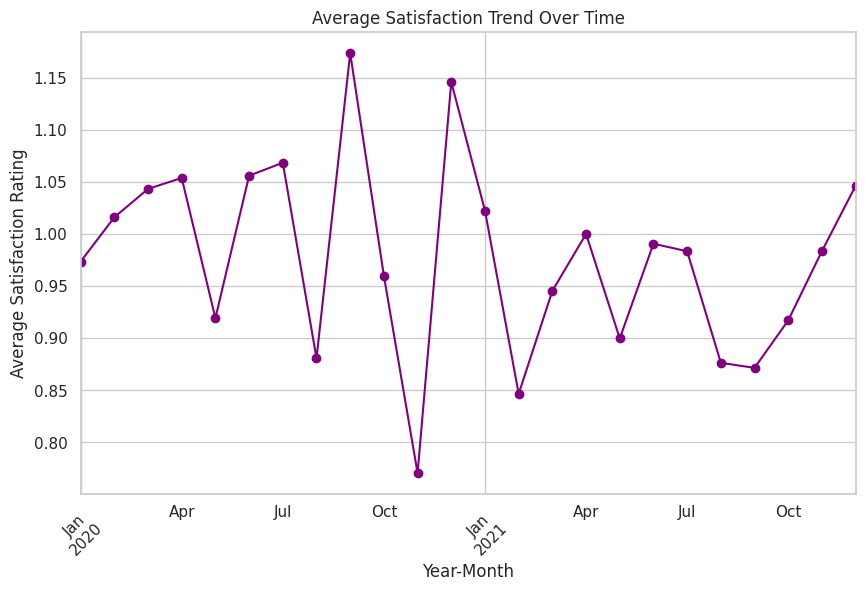

In [86]:
#Line Plot: Satisfaction Trend by Year-Month
data['YearMonth'] = data['Date of Purchase'].dt.to_period('M')
satisfaction_trend = data.groupby('YearMonth')['Customer Satisfaction Rating'].mean()
plt.figure(figsize=(10, 6))
satisfaction_trend.plot(kind='line', marker='o', color='purple')
plt.title('Average Satisfaction Trend Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Average Satisfaction Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

/tmp/ipython-input-87-4105977006.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Customer Satisfaction Rating', y='Word Count', data=data, palette='magma')


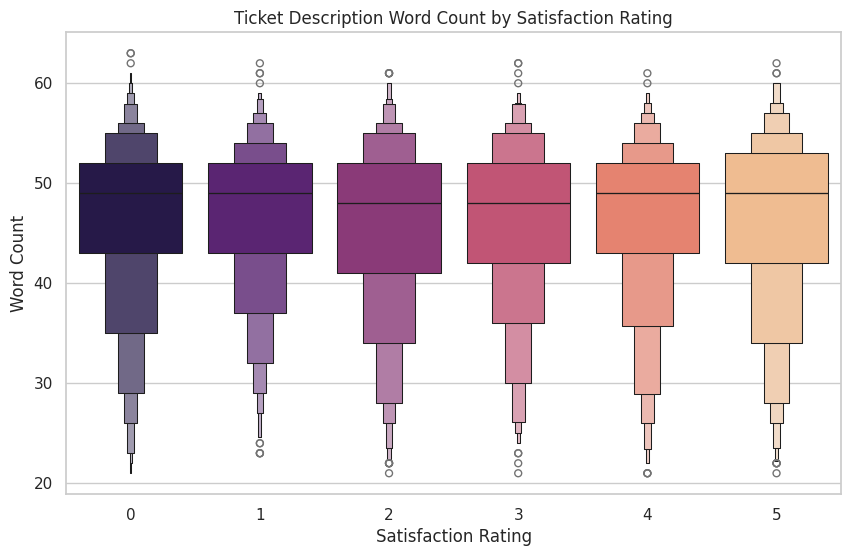

In [87]:
#Boxen Plot: Word Count by Satisfaction Rating
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Customer Satisfaction Rating', y='Word Count', data=data, palette='magma')
plt.title('Ticket Description Word Count by Satisfaction Rating')
plt.xlabel('Satisfaction Rating')
plt.ylabel('Word Count')
plt.show()

In [88]:
# Import necessary libraries
import plotly.express as px

# Sunburst Plot: Product Purchased by Gender and Satisfaction
fig = px.sunburst(data,path=['Customer Gender', 'Product Purchased', 'Customer Satisfaction Rating'],values='Ticket ID',title='Product Purchased by Gender and Satisfaction')
fig.update_layout(width=800, height=600)
fig.show()

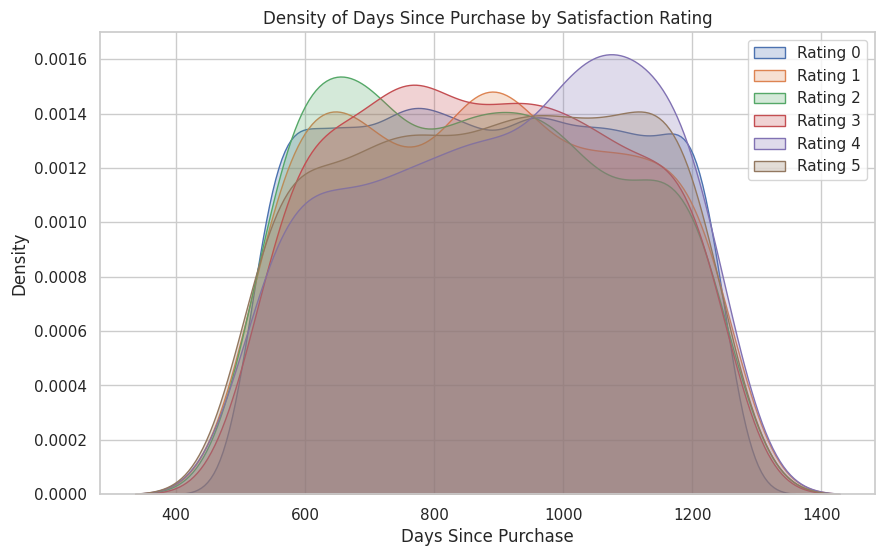

In [89]:
#Density Plot: Days Since Purchase by Satisfaction
plt.figure(figsize=(10, 6))
for rating in sorted(data['Customer Satisfaction Rating'].unique()):
    sns.kdeplot(data=data[data['Customer Satisfaction Rating'] == rating]['Days Since Purchase'], label=f'Rating {int(rating)}', fill=True)
plt.title('Density of Days Since Purchase by Satisfaction Rating')
plt.xlabel('Days Since Purchase')
plt.ylabel('Density')
plt.legend()
plt.show()


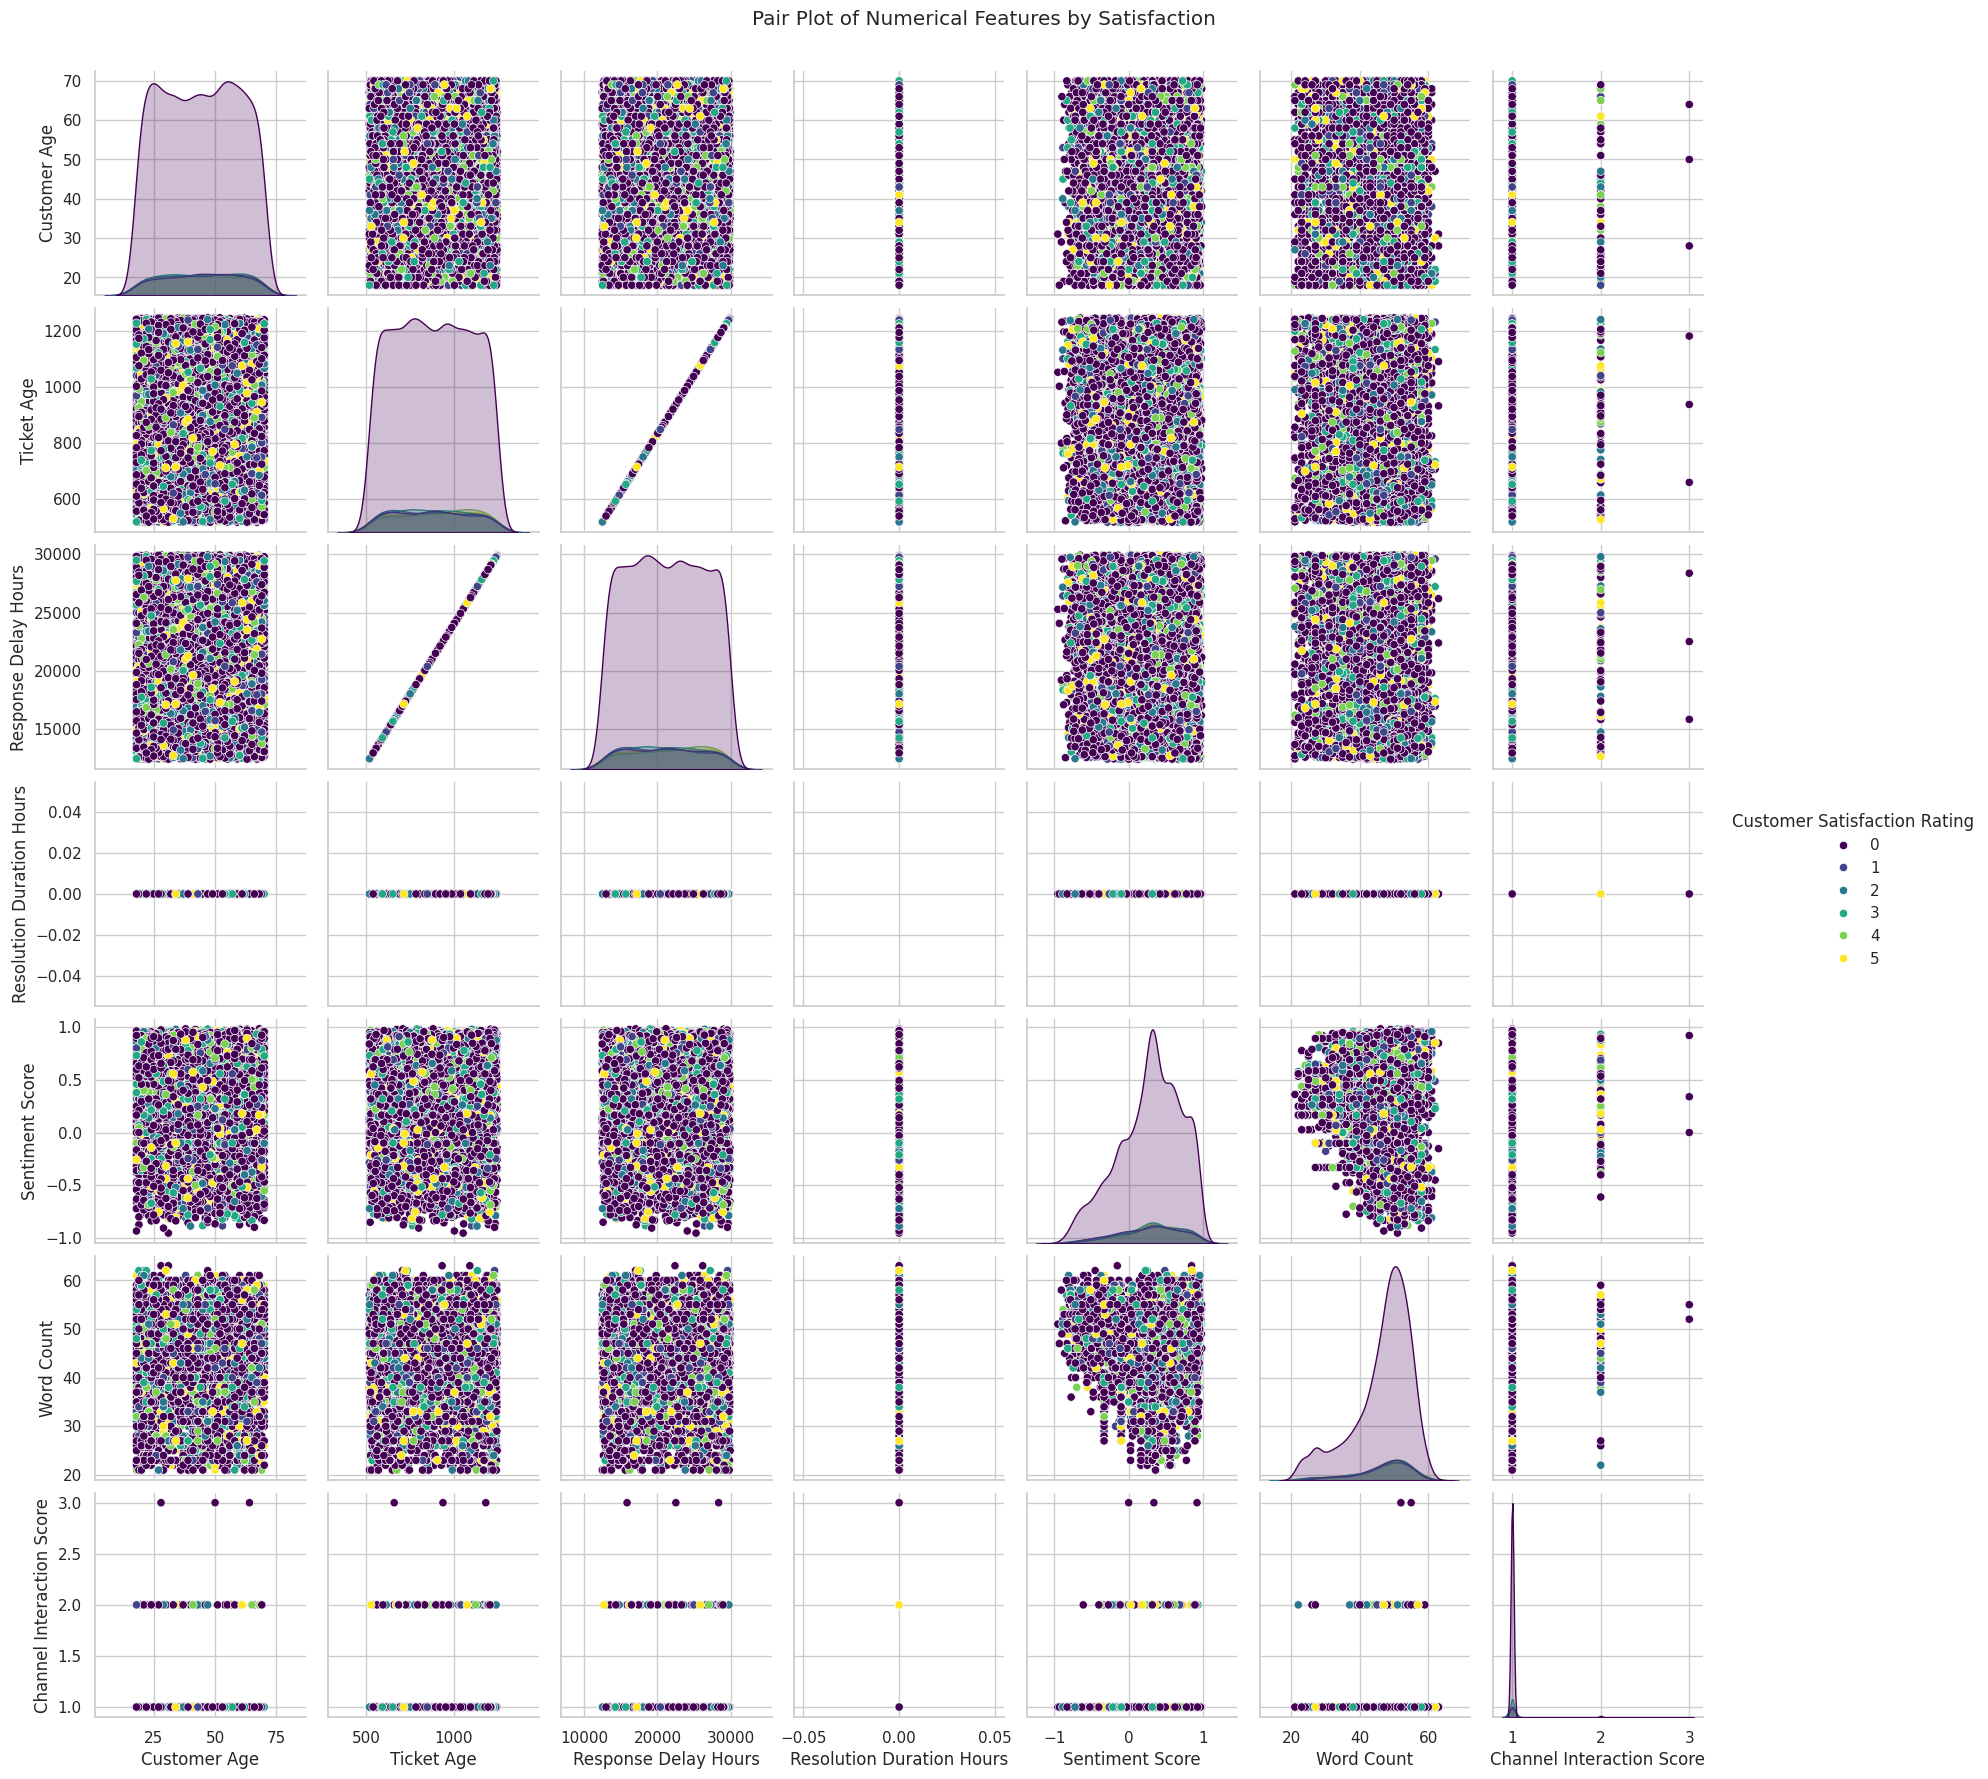

In [91]:
#Pair Plot: Numerical Features (subset for brevity)
sns.pairplot(data[numerical_cols + ['Customer Satisfaction Rating']], hue='Customer Satisfaction Rating', palette='viridis')
plt.suptitle('Pair Plot of Numerical Features by Satisfaction', y=1.02)
plt.show()

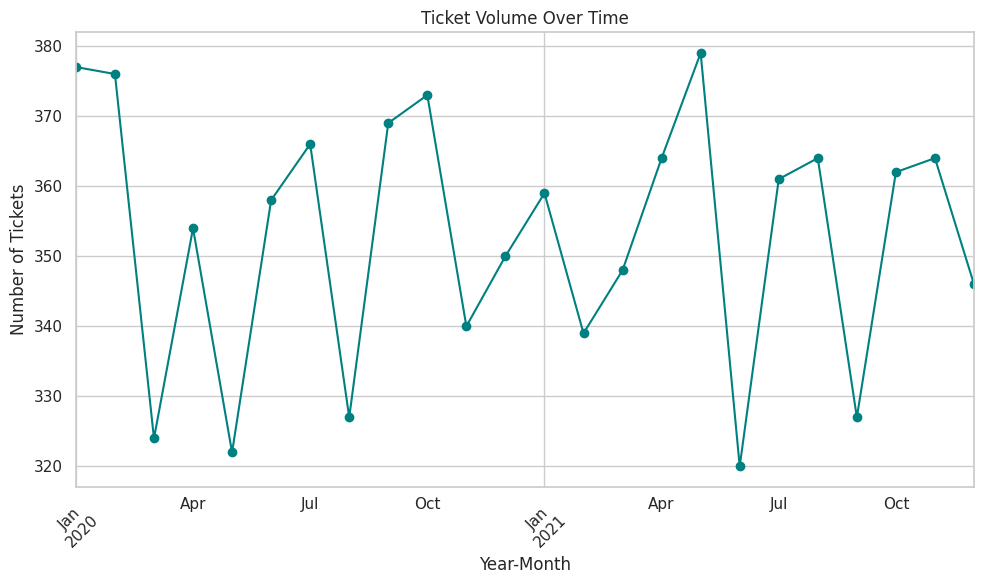

In [92]:
#Time Series Plot: Ticket Volume by Month
data['YearMonth'] = data['Date of Purchase'].dt.to_period('M')
ticket_trends = data.groupby('YearMonth').size()
plt.figure(figsize=(10, 6))
ticket_trends.plot(kind='line', marker='o', color='teal')
plt.title('Ticket Volume Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Number of Tickets')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [93]:
# Install wordcloud library
!pip install wordcloud

# Import necessary libraries
from wordcloud import WordCloud

In [94]:
# Word Cloud: Ticket Description for Low vs High Satisfaction
low_satisfaction_text = ' '.join(data[data['Customer Satisfaction Rating'] <= 2]['Ticket Description'].dropna())
high_satisfaction_text = ' '.join(data[data['Customer Satisfaction Rating'] >= 4]['Ticket Description'].dropna())


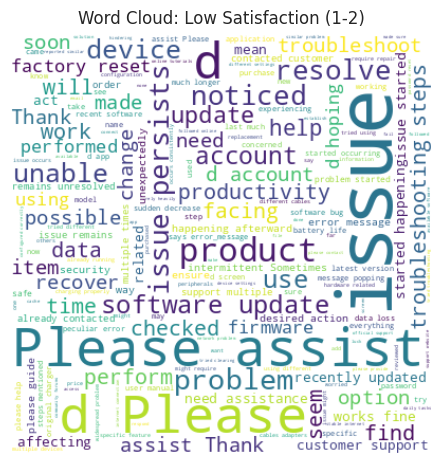

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Now WordCloud is defined
wordcloud_low = WordCloud(width=400, height=400, background_color='white').generate(low_satisfaction_text)
plt.imshow(wordcloud_low, interpolation='bilinear')
plt.title('Word Cloud: Low Satisfaction (1-2)')
plt.axis('off')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
# Now WordCloud is defined
wordcloud_high = WordCloud(width=400, height=400, background_color='white').generate(high_satisfaction_text)
plt.imshow(wordcloud_high, interpolation='bilinear')
plt.title('Word Cloud: High Satisfaction (4-5)')
plt.axis('off')
plt.show()